# Moskalev Artem. HW 1.

# Problem 1

**Capacitated facility location**

You need to solve a *capacitated facility location* problem. There are a number of clients that can be served by a number of potential facilities. As in the case of a common (uncapacitated) facility location problem, you need to decide which facilities to open (paying the opening cost for each) and which clients to serve at each facility (paying the assignment cost). Each client must be assigned to one opened facility. In addition, you have a cap on how many clients each facility can serve. As usual, you want to minimize the costs.

Implement the following algorithms and investigate them. Use the below code to generate the data, and to visualize the results. You are supposed to play with different configurations and problem sizes. Please make your report detailed (otherwise lower amount of points than indicated may be assigned).

* (2 points). Implement a **greedy algorithm** for the problem.
* (3 points). Implement **some local optimization algorithm**. Try to design powerful moves that are at the same time easy to search through. **Important:** your move should connect the whole domain, i.e. for any pair of feasible solutions, there should exist a sequence of moves from the family you design that transform one solution to the other.
* (3 points). Implement the **simulated annealing algorithm** based on the best of your local optimization algorithms. Play with the schedule and see how it affects the results. Compare with the local optimization algorithm that you base upon. Note, that if implemented correctly, simulated annealing should improve over the local optimization algorithm.

Below is the Gurobi solution that uses a mixed-integer solver (we will come to that in week 3). You can use it as a reference for small instances (for which it will give you a global optimum), and also reuse the visualization code.

Before writing your code, study the cells below to learn variables, convention for the solution format etc.

In [1]:
import numpy as np
import scipy as sp
import math
import random
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt
from gurobipy import GRB
import gurobipy as grb

%matplotlib inline

class Problem:
    def __init__(self, C=20, F=15):
        self.C = C
        self.F = F
        
        self.clients = np.random.rand(2, C)    # client positions
        self.facilities = np.random.rand(2, F) # facility positions

        # maximum number of clients per facility
        self.capacities = np.ones((F,), dtype=np.int32)*4;

        # assignment cost is defined as the squared distance between a client and a facility
        dx = \
            np.matlib.repmat(self.clients[0,:],F,1) - \
            np.matlib.repmat(self.facilities[0,:],C,1).transpose();
        dy = \
            np.matlib.repmat(self.clients[1,:],F,1) - \
            np.matlib.repmat(self.facilities[1,:],C,1).transpose();

        self.assignment_costs = 3*(dx*dx + dy*dy);

        self.opening_costs = np.ones((F,));
    
    def assign_random_capacities(self):
        """
        Assign more or less random capacities to facilities.
        
        This is one of the possible ways to change the problem configuration.
        In other words, use this function when testing your solution!
        """
        while True:
            self.capacities = \
                np.random.randint(2*self.C // self.F, size=self.F) + 1
            if sum(self.capacities) > self.C * 1.3:
                break
    
    def assign_random_opening_costs(self):
        """
        Assign more or less random opening costs to facilities.
        
        Same as above -- use this for your report.
        """
        # could be float, but let it be simple
        self.opening_costs = \
            np.random.randint((self.C+self.F-1) // self.F, size=self.F) + 1
    
    def plot(self, y, assignments, fig=plt):
        """
        Plot the given solution (y, assignments)
        
        Arguments:
        y, assignments -- see Problem.objective().
        fig            -- an instance of matplotlib.axes._axes.Axes to draw on.
                          Also, can be matplotlib.pyplot, in this case use the default Axes.
                          This is useful to compare your results (see "Results comparison" section).
        """
        y = np.array(y)
        assignments = np.array(assignments)
        y = y.astype(np.int32)
        assignments = assignments.astype(np.int32)

        
        for cli,fac in enumerate(assignments):
            fig.plot([self.clients[0,cli], self.facilities[0,fac]], \
                     [self.clients[1,cli], self.facilities[1,fac]], c=(.7,.7,.7))
            
        fig.scatter(self.clients[0,:], self.clients[1,:], s=15.0, c=assignments, \
                    vmin=0, vmax=self.F-1)
        
        fig.scatter(self.facilities[0,:], self.facilities[1,:], s=54.0, \
                    c=range(self.F), linewidth = [1*el for el in y])
        
    def objective(self, y, assignments):
        """
        Return objective function value given a solution.
        If the solution is infeasible, return infinity.
        
        Arguments:
        y           -- a binary 1D array of size F. y[i] is 1 iff i-th facility is open.
        assignments -- an integer 1D array of size C. assignments[i] is index of facility
                       that i-th client is assigned to.
        """
        assert len(y) == self.F
        assert len(assignments) == self.C
        
        y = np.array(y)
        assignments = np.array(assignments)
        y = y.astype(np.int32)
        assignments = assignments.astype(np.int32)
        
        retval = sum(is_opened*opening_cost \
                     for is_opened, opening_cost in zip(y, self.opening_costs))
        
        assignment_counts = np.zeros_like(y)
        
        for cli,fac in enumerate(assignments):
            if not y[fac]:
                return np.inf
            else:
                retval += self.assignment_costs[fac,cli]
                assignment_counts[fac] += 1
                
        if any(assignment_counts > self.capacities):
            return np.inf
            
        return retval
        
    def solve_gurobi(self, verbose=False):
        """
        Solve the problem using mixed integer program solver.
        Return `y, assignments` (see Problem.objective() docstring for format).
        
        Arguments:
        verbose -- controls Gurobi output.
        """
        m = grb.Model("facility")

        y = []
        for i_f in range(self.F):
            y.append(m.addVar(vtype=GRB.BINARY))

        x = []    
        for i_f in range(self.F):
            x.append([])
            for i_c in range(self.C):
                x[i_f].append(m.addVar(vtype=GRB.BINARY))

        # the objective is to minimize the total fixed and variable costs
        m.modelSense = GRB.MINIMIZE

        # update model to integrate new variables
        m.update()

        # set optimization objective - minimize sum of fixed costs
        obj_summands = []
        for i_f in range(self.F):
            obj_summands.append(self.opening_costs[i_f]*y[i_f])

        for i_f in range(self.F):
            for i_c in range(self.C):
                obj_summands.append(self.assignment_costs[i_f][i_c]*x[i_f][i_c])

        m.setObjective(grb.quicksum(obj_summands))

        # set constraints
        for i_c in range(self.C):
            client_constr_summands = [x[i_f][i_c] for i_f in range(self.F)]
            m.addConstr(sum(client_constr_summands), GRB.EQUAL, 1.0)

        for i_f in range(self.F):        
            facility_constr_summands = [x[i_f][i_c] for i_c in range(self.C)]
            m.addConstr(sum(facility_constr_summands), GRB.LESS_EQUAL, self.capacities[i_f]*y[i_f])       

        for i_f in range(self.F):        
            for i_c in range(self.C):
                m.addConstr(x[i_f][i_c], GRB.LESS_EQUAL, y[i_f])

        # optimize
        m.setParam(GRB.Param.OutputFlag, verbose)
        m.optimize()
        
        facilities_opened = [y[i_f].X for i_f in range(self.F)]
        clients_assignment = \
            [i_f for i_c in range(self.C) for i_f in range(self.F) if x[i_f][i_c].X != 0]
        
        return facilities_opened, clients_assignment

The following example shows `Problem` class usage.

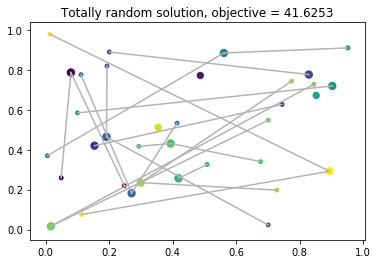

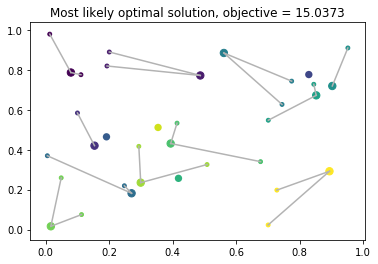

In [2]:
# to make results reproducible, be sure to put this line before creating a Problem()
np.random.seed(666)

problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

# completely random solution
open_idx = list(range(problem.F))
random.shuffle(open_idx)
open_idx = open_idx[:problem.F * 4 // 5] # open 80% of facilities

y = np.zeros(problem.F)
y[open_idx] = 1

from itertools import cycle
assignments = np.empty(problem.C)
for cli, fac in zip(range(problem.C), cycle(open_idx)):
    assignments[cli] = fac

ax = plt.figure().gca()
problem.plot(y, assignments, ax)
ax.set_title('Totally random solution, objective = %.4f' % problem.objective(y, assignments))

ax = plt.figure().gca()
y, assignments = problem.solve_gurobi()
problem.plot(y, assignments, ax)
ax.set_title('Most likely optimal solution, objective = %.4f' % problem.objective(y, assignments))

## Greedy algorithm

*(Describe your greedy algorithm here)*

THE MAIN IDEA OF AN ALGORITHM:

1) On each iteration, we find the minimum total cost (possible_optima) in a total_cost table. We have a result in form of (row, column) tuple.

2) We check if the facility associated with our possible_optima is available (capacity threshold is not reached).

3) If it is not available, we substitute the minimum value in total_cost table with some big number (abs_max), to avoid it to be found by as minimum in future and return to the step 1).

4) If it is available, we full the column, corresponding to the client, which possible_optima we just found, with abs_max to exclude it from a future search of minimums.

5) Then we subtract -1 from the capacity of the corresponding facility

6) On the final stage, we just write our result in 'assignment' and 'y' variables

So, all in all, we do Greedy NN (with N=1) algorithm with some constraints over capacity.

In [3]:
def solve_greedy(self,return_capacties=False):
    y = np.empty(self.F, dtype=np.int32)
    assignments = np.empty(self.C, dtype=np.int32)

    # your code here
    y = np.zeros(problem.F, dtype=np.int32) # let's make all facilities closed by default
    
    total_cost = self.assignment_costs.copy() #let's copy assignment_costs table, so we can safly modify it
    #Next, we want produce table of total costs, where total cost 
    #is equal to the cost of assignment + cost of opening for particular facility
    #Code below does this summation
    for each_facility_row in range(total_cost.shape[0]):
        total_cost[each_facility_row] += self.opening_costs[each_facility_row]
    
    # we will substract one from corresponding capacity each time when we achived to find possible_optime
    # so we just copy capacities array
    full_capacities = self.capacities.copy()
    
    abs_max=total_cost.max()*10 #we save maximum value to substitute possible_optimas, which doesn't satisfy constraints
    
    #we iterate till all clients are served, so clients = (initial capacities)-(capacities after all client are assigned)
    #the algorithm below described in the cell above
    while sum(self.capacities)-sum(full_capacities) != self.clients.shape[1]:
        while True:
            possible_optima = np.unravel_index(total_cost.argmin(), total_cost.shape)
            if full_capacities[possible_optima[0]] == 0:
                total_cost[possible_optima] = abs_max
            else:
                #if we openned a facility, we need to substract an opening cost from total cost, since we should take
                #only assignment cost into account for this particular facility in future
                total_cost[possible_optima[0],:] -= self.opening_costs[possible_optima[0]]
                total_cost[:,possible_optima[1]] = abs_max
                break
        full_capacities[possible_optima[0]] -= 1
        assignments[possible_optima[1]] = possible_optima[0]
    opened_facilities = np.unique(assignments)
    for facility_idx in range(y.shape[0]):
        if facility_idx in opened_facilities:
            y[facility_idx] = 1
    if return_capacties:
        return y, assignments,full_capacities
    else:
        return y, assignments

Problem.solve_greedy = solve_greedy

*(Demonstrate your greedy algorithm here)*

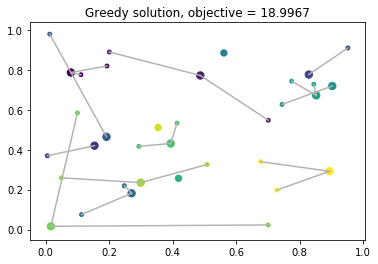

In [4]:
np.random.seed(666)

problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

ax = plt.figure().gca()
y, assignments = problem.solve_greedy()
problem.plot(y, assignments, ax)
ax.set_title('Greedy solution, objective = %.4f' % problem.objective(y, assignments))

In [5]:
np.random.seed(None)

score=[]
for i in range(100): 
    problem = Problem()
    problem.assign_random_capacities()
    problem.assign_random_opening_costs()
    score.append(problem.objective(*problem.solve_greedy()))
print('Greedy algorithm average score:' ,np.mean(score))

Greedy algorithm average score: 19.8559121786


## Local optimization algorithm

*(Describe your local optimization algorithm here. Make sure that its moves cover the whole solution domain)*

For local optimization, we will try two approaches. Firstly, we will begin with generating an absolutely random solution and then try to iteratively improve it. Second, we will use our greedy algorithm solution as a basis and then will try to enhance it with local optimization. For both purposes, we will create one algorithm with some parameters.

An idea of an algorithm:

1) Either generate random solution or accept particular one

2) Randomly choose one client and a facility which is not overloaded (in terms of capacity) and is not the current client's facility or randomly permute one connection

3) We connect this client to this facility and assume that our solution that was shifted by this random permutation will perform better

4) We check if its performance really improved. If yes - save shifted solution to 'y' and 'assignments' variables and update capacities. If no - our pick is not the best, so we don't save it and just move to the next iteration (step 2)

In [6]:
def solve_local_optimization(self, greedy_base=False, max_iter=10000):
            
    y = np.empty(self.F, dtype=np.int32)
    assignments = np.empty(self.C, dtype=np.int32)
    
    if greedy_base:
        y, assignments, full_capacities = self.solve_greedy(return_capacties=True)
    else:
        def generate_random_sol():
            y = np.ones(problem.F, dtype=np.int32)
            full_capacities = self.capacities.copy()
            for each_client in range(self.C):
                while True:
                    facility_idx = np.random.randint(0,y.shape[0])
                    if full_capacities[facility_idx] != 0:
                        full_capacities[facility_idx] -= 1
                        break
                assignments[each_client] = facility_idx
            y = [int(i in np.unique(assignments)) for i in range(y.shape[0])] #let's close facilities that are not used
            return np.array(y), np.array(assignments), full_capacities

        y, assignments, full_capacities = generate_random_sol()
    
    while max_iter!=0:
        #here we take neighborhood solution
        def neighbor_1():
            
            global possibly_better_y
            global possibly_better_assignment
            global client_idx
            global facility_idx
    
            client_idx=np.random.randint(0,self.C)
            while True:
                facility_idx = np.random.randint(0,self.F)
                if full_capacities[facility_idx] != 0 and assignments[client_idx] != facility_idx:
                    break
            possibly_better_assignment = assignments.copy()
            possibly_better_assignment[client_idx] = facility_idx
            try:
                possibly_better_y = [int(i in np.unique(possibly_better_assignment)) for i in range(y.shape[0])]
            except:
                possibly_better_y = [int(i in np.unique(possibly_better_assignment)) for i in range(len(y))]

        
        def neighbor_2():
            global possibly_better_y
            global possibly_better_assignment
            possibly_better_assignment = assignments.copy()
            while True:
                rand_idx_1 = np.random.randint(0,np.max(possibly_better_assignment.shape))
                rand_idx_2 = np.random.randint(0,np.max(possibly_better_assignment.shape))
                if rand_idx_1 != rand_idx_2:
                    break
            permute_1=possibly_better_assignment[rand_idx_1].copy()
            permute_2=possibly_better_assignment[rand_idx_2].copy()
            possibly_better_assignment[rand_idx_1] = permute_2
            possibly_better_assignment[rand_idx_2] = permute_1
            
            try:
                possibly_better_y = [int(i in np.unique(possibly_better_assignment)) for i in range(y.shape[0])]
            except:
                possibly_better_y = [int(i in np.unique(possibly_better_assignment)) for i in range(len(y))]
                
            
        np.random.seed(None)
        
        if bool(np.random.randint(0,2)):
            neighbor_1()
        else:
            neighbor_2()
        
        def recalculate_openned_facilities():
            opened_facilities = np.unique(possibly_better_assignment)
            for each_facility in range(self.F):
                if possibly_better_y[each_facility] in opened_facilities:
                    possibly_better_y[each_facility]=1
                else:
                    possibly_better_y[each_facility]=0
                    
        #here we check if the result of new solution is better
        #If yes we reassign y, assignments and correspondin capacities
        if self.objective(possibly_better_y, possibly_better_assignment) < self.objective(y, assignments):
            old_assignment=assignments[client_idx]
            assignments = possibly_better_assignment.copy()
            y = possibly_better_y.copy()
            full_capacities[old_assignment] +=1
            full_capacities[facility_idx] -=1
            recalculate_openned_facilities()
        max_iter-=1
    
    return y, assignments
        
Problem.solve_local_optimization = solve_local_optimization

So, first, let's try to do local optimization based on completely random solution:

In [7]:
np.random.seed(666)
problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

np.random.seed(None)
score=[]
for i in range(10): 
    score.append(problem.objective(*problem.solve_local_optimization()))
print('Local optmization algorithm average score:' , np.mean(score))

Local optmization algorithm average score: 17.5638553896


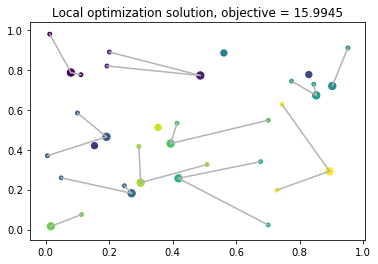

In [8]:
np.random.seed(666)
problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

np.random.seed(None)
ax = plt.figure().gca()
y, assignments = problem.solve_local_optimization()
problem.plot(y, assignments, ax)
ax.set_title('Local optimization solution, objective = %.4f' % problem.objective(y, assignments))

Let's also experiment and try to improve our greedy solution with local search, giving our local search algorithm our greedy solution as an initial state:

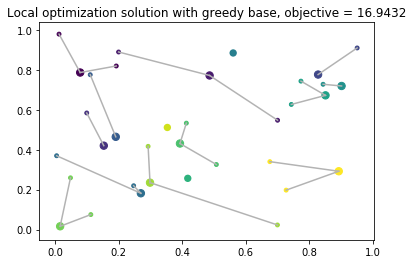

In [9]:
np.random.seed(666)

problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

np.random.seed(None)
ax = plt.figure().gca()
y, assignments = problem.solve_local_optimization(greedy_base=True)
problem.plot(y, assignments, ax)
ax.set_title('Local optimization solution with greedy base, objective = %.4f' % problem.objective(y, assignments))

Seems like an approach based on enhancing our greedy algorithm's solution with local search gave us good result, but since it neither greedy nor local optimization, but some mixture, we will not consider it in this assignment. 

## Simulated annealing

Since we are asked to base simulated annealing on local search, I will reuse my previous code for local search algorithm but will change the decision rule. 

And as well as in the previous section, we will try to improve the performance of local search based on random initial solution and based on our greedy solution.

For temperature scheduling we will try 3 oprions: ordinary exponential, linear and logarithmic. All of them are well described in these papers: 

1) http://www.fys.ku.dk/~andresen/BAhome/ownpapers/permanents/annealSched.pdf

2) http://what-when-how.com/artificial-intelligence/a-comparison-of-cooling-schedules-for-simulated-annealing-artificial-intelligence/

In [10]:
def solve_simulated_annealing(self, max_iter=10000, greedy_base=False, T_0=100, y_t=0.999, schedule='exp', verbose=False):
    # your code here. You can add function parameters as needed.
    # You are expected to implement several temperature schedules
    
    y = np.empty(self.F, dtype=np.int32)
    assignments = np.empty(self.C, dtype=np.int32)
    
    if greedy_base:
        y, assignments, full_capacities = self.solve_greedy(return_capacties=True)
    else:
        def generate_random_sol():
            y = np.ones(problem.F, dtype=np.int32)
            full_capacities = self.capacities.copy()
            for each_client in range(self.C):
                while True:
                    facility_idx = np.random.randint(0,y.shape[0])
                    if full_capacities[facility_idx] != 0:
                        full_capacities[facility_idx] -= 1
                        break
                assignments[each_client] = facility_idx
            y = [int(i in np.unique(assignments)) for i in range(y.shape[0])] #let's close facilities that are not used
            return np.array(y), np.array(assignments), full_capacities

        y, assignments, full_capacities = generate_random_sol()
    
    while max_iter!=0:
        #here we take neighborhood solution
        def neighbor_1():
            
            global possibly_better_y
            global possibly_better_assignment
            global client_idx
            global facility_idx
    
            client_idx=np.random.randint(0,self.C)
            while True:
                facility_idx = np.random.randint(0,self.F)
                if full_capacities[facility_idx] != 0 and assignments[client_idx] != facility_idx:
                    break
            possibly_better_assignment = assignments.copy()
            possibly_better_assignment[client_idx] = facility_idx
            try:
                possibly_better_y = [int(i in np.unique(possibly_better_assignment)) for i in range(y.shape[0])]
            except:
                possibly_better_y = [int(i in np.unique(possibly_better_assignment)) for i in range(len(y))]

        
        def neighbor_2():
            global possibly_better_y
            global possibly_better_assignment
            possibly_better_assignment = assignments.copy()
            while True:
                rand_idx_1 = np.random.randint(0,np.max(possibly_better_assignment.shape))
                rand_idx_2 = np.random.randint(0,np.max(possibly_better_assignment.shape))
                if rand_idx_1 != rand_idx_2:
                    break
            permute_1=possibly_better_assignment[rand_idx_1].copy()
            permute_2=possibly_better_assignment[rand_idx_2].copy()
            possibly_better_assignment[rand_idx_1] = permute_2
            possibly_better_assignment[rand_idx_2] = permute_1
            
            try:
                possibly_better_y = [int(i in np.unique(possibly_better_assignment)) for i in range(y.shape[0])]
            except:
                possibly_better_y = [int(i in np.unique(possibly_better_assignment)) for i in range(len(y))]
                
            
        np.random.seed(None)
        
        if bool(np.random.randint(0,2)):
            neighbor_1()
        else:
            neighbor_2()
        
        def recalculate_openned_facilities():
            opened_facilities = np.unique(possibly_better_assignment)
            for each_facility in range(self.F):
                if possibly_better_y[each_facility] in opened_facilities:
                    possibly_better_y[each_facility]=1
                else:
                    possibly_better_y[each_facility]=0
        
        cost_delta = self.objective(possibly_better_y, possibly_better_assignment) - self.objective(y, assignments)
        #as we are minimizing the total cost, negative cost_delta signals that we found an improvement
        if cost_delta<=0 or math.exp(-cost_delta/T_0) > random.random(): 
            old_assignment=assignments[client_idx]
            assignments = possibly_better_assignment.copy()
            y = possibly_better_y.copy()
            full_capacities[old_assignment] +=1
            full_capacities[facility_idx] -=1
            recalculate_openned_facilities()
              
        max_iter-=1
        
        if schedule == 'exp':
            T_0 *= y_t
        elif schedule == 'lin':
            T_0 -= y_t
        elif schedule == 'log':
            T_0 /= (1+y_t*np.log(1+max_iter))
            
        if verbose and max_iter%50 == 0: print(T_0)
            
    return y, assignments

Problem.solve_simulated_annealing = solve_simulated_annealing

Let's compare how our simmulated annealing algorithm will work with diffrent schedules:

In [11]:
np.random.seed(666)
problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

np.random.seed(None)

score=[]
for i in range(10):
    score.append(problem.objective(*problem.solve_simulated_annealing(T_0=1000)))
print('SA with exponential schedule:',np.mean(score))

score=[]
for i in range(10):
    score.append(problem.objective(*problem.solve_simulated_annealing(schedule='log',y_t=0.005)))
print('SA with log schedule:',np.mean(score))

SA with exponential schedule: 17.653652269
SA with log schedule: 17.3620531809


I could fix random seed to compare these approaches, however I feel like I will hurt performance by doing that. Randomness is used widly on each stage and iteration. So, I just actually ran all of them several times to get more fair estimations. I tried to adjust default parameters to make them more or less conform with temperature schedules.

For future investigation I suggest using of exponential schedule. It performed well and will be easier to tune. So, let's play with temperature, decreasing speed and number of iterations. Let's create a function to run our algorithm several times and then calculate the mean of its performance. Again, we don't want to fix a random seed.

In [12]:
def fair_performance_estimator(max_iter=10000, T_0=100, y_t=0.999, schedule='exp'):
    score = []
    for i in range(10):
        score.append(problem.objective(*problem.solve_simulated_annealing(max_iter=max_iter, T_0=T_0, y_t=y_t,schedule=schedule)))
    return np.mean(score)

In [13]:
#default: max_iter=10000, T_0=100, y_t=0.999. Performace: 20.66
np.random.seed(666)
problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

np.random.seed(None)
print('SA with exp.schedule T_0=5000, max_iter=20000:', fair_performance_estimator(T_0=5000, max_iter=20000))
print('SA with exp.schedule T_0=5000, max_iter=20000,y_t=0.995:', fair_performance_estimator(T_0=5000, max_iter=20000,y_t=0.995))

SA with exp.schedule T_0=5000, max_iter=20000: 16.6415555896
SA with exp.schedule T_0=5000, max_iter=20000,y_t=0.995: 16.6745713354


In [14]:
print('SA with exp.schedule T_0=2000, max_iter=20000:', fair_performance_estimator(T_0=2000, max_iter=20000))
print('SA with exp.schedule T_0=1000, max_iter=40000:', fair_performance_estimator(T_0=1000, max_iter=40000))
print('SA with exp.schedule T_0=1000, max_iter=20000,y_t=0.99:', fair_performance_estimator(T_0=1000, max_iter=20000,y_t=0.99))
print('SA with exp.schedule T_0=3000, max_iter=20000, y_t=0.991:', fair_performance_estimator(T_0=3000, max_iter=20000, y_t=0.991))

SA with exp.schedule T_0=2000, max_iter=20000: 17.3490125278
SA with exp.schedule T_0=1000, max_iter=40000: 17.1543868129
SA with exp.schedule T_0=1000, max_iter=20000,y_t=0.99: 17.0199280304
SA with exp.schedule T_0=3000, max_iter=20000, y_t=0.991: 16.9410644008


Above, there are just several experiments that I did, I actually experimented a lot, but in order to not overload the report, I leaved only them.

We see that the best objective is reached with parameters T_0=1000, max_iter=20000, so let's use them as final. 

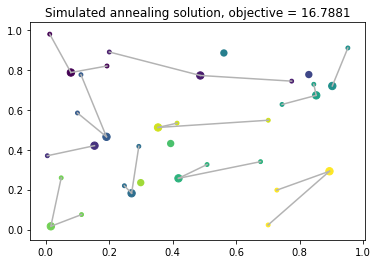

In [15]:
np.random.seed(666)

problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

np.random.seed(None)
ax = plt.figure().gca()
y, assignments = problem.solve_simulated_annealing(T_0=2000, max_iter=20000)
problem.plot(y, assignments, ax)
ax.set_title('Simulated annealing solution, objective = %.4f' % problem.objective(y, assignments))

It is possible to observe that simmulated annealing algoritm overperforms local optimization algorithm. It also beats simple local search on average score. Furthermore, it uses less iterations to reach optima, so it's more likely to use.

## Results comparison

*(Compare 4 methods (with their best parameters) on different problems, capacities etc. Don't forget corner cases like $C \gg F$, $C = F$, $\dots$)*

In [16]:
# Suggested code for comparison (modify as needed)

def compare_results(problem):
    fig = plt.figure()

    ax_greedy = fig.add_subplot(221)
    ax_local  = fig.add_subplot(222)
    ax_anneal = fig.add_subplot(223)
    ax_gurobi = fig.add_subplot(224)

    greedy = problem.solve_greedy()
    local  = problem.solve_local_optimization()
    gurobi = problem.solve_gurobi()
    anneal = problem.solve_simulated_annealing(T_0 = 2000, max_iter=20000)

    ax_greedy.set_title('Greedy:    %.3f' % problem.objective(*greedy))
    ax_local .set_title('Local:     %.3f' % problem.objective(*local))
    ax_anneal.set_title('Annealing: %.3f' % problem.objective(*anneal))
    ax_gurobi.set_title('Gurobi:    %.3f' % problem.objective(*gurobi))

    problem.plot(greedy[0], greedy[1], ax_greedy)
    problem.plot(local [0], local [1], ax_local )
    problem.plot(anneal[0], anneal[1], ax_anneal)
    problem.plot(gurobi[0], gurobi[1], ax_gurobi)

    for ax in ax_greedy, ax_local, ax_anneal, ax_gurobi:
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

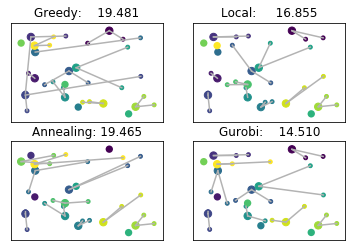

In [17]:
np.random.seed(321)

problem = Problem()
problem.assign_random_capacities()
problem.assign_random_opening_costs()

np.random.seed(None)
compare_results(problem)

Seems reasonable, let's also check border cases: C=F and C>>F

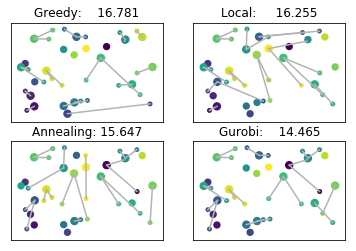

In [18]:
np.random.seed(321)

problem = Problem(C=20, F=20)
problem.assign_random_capacities()
problem.assign_random_opening_costs()

np.random.seed(None)
compare_results(problem)

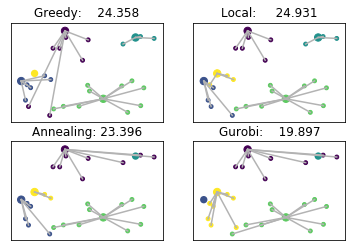

In [19]:
np.random.seed(321)

problem = Problem(C=25, F=5)
problem.assign_random_capacities()
problem.assign_random_opening_costs()

np.random.seed(None)
compare_results(problem)

Done, all our algorithms work correctly even in border cases.